1. Load and Preprocess the Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('uber.csv')

# View sample
print(df.head())
print(df.info())


   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217              1.0  
1         -73.994710         40.750325              1.0  
2         -73.962565         40.772647              1.0  
3         

Clean and preprocess:

In [ ]:
# Convert pickup_datetime to datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

# Drop rows with missing values
df.dropna(inplace=True)

# Remove entries with invalid coordinates
df = df[(df['pickup_latitude'].between(-90, 90)) &
        (df['pickup_longitude'].between(-180, 180)) &
        (df['dropoff_latitude'].between(-90, 90)) &
        (df['dropoff_longitude'].between(-180, 180))]

# Remove fares <= 0
df = df[df['fare_amount'] > 0]

# Create new features
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year

# Calculate distance (haversine)
from geopy.distance import geodesic

def haversine_distance(row):
    start = (row['pickup_latitude'], row['pickup_longitude'])
    end = (row['dropoff_latitude'], row['dropoff_longitude'])
    return geodesic(start, end).km

df['distance_km'] = df.apply(haversine_distance, axis=1)


 2. Identify Outliers

Text(0.5, 1.0, 'Distance Outliers')

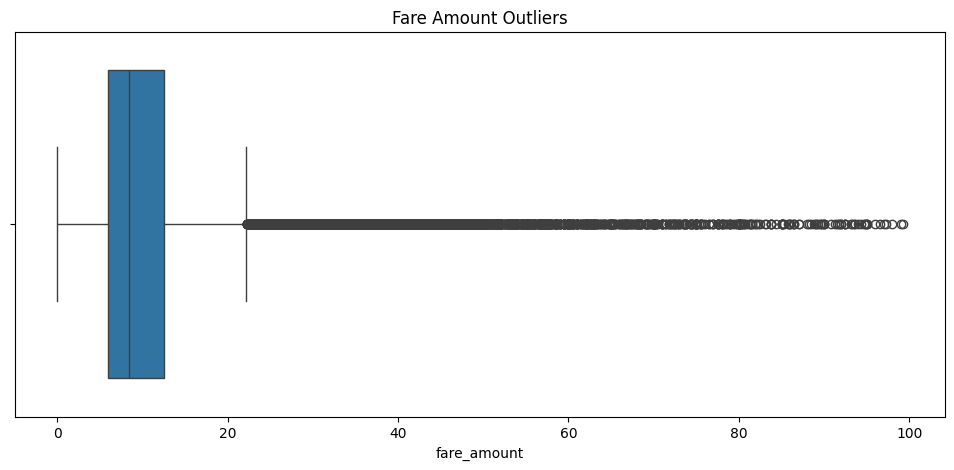

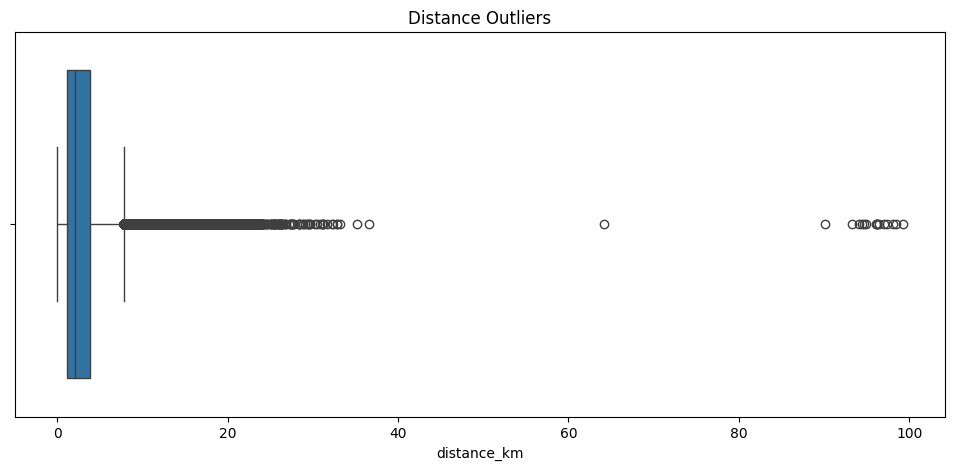

In [ ]:
# Visualize fare_amount and distance
plt.figure(figsize=(12, 5))
sns.boxplot(x=df['fare_amount'])
plt.title("Fare Amount Outliers")

plt.figure(figsize=(12, 5))
sns.boxplot(x=df['distance_km'])
plt.title("Distance Outliers")



In [ ]:
# 4. Remove Outliers Using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f"{column} IQR bounds: {lower_bound:.2f} to {upper_bound:.2f}")
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df = remove_outliers_iqr(df, 'fare_amount')
df = remove_outliers_iqr(df, 'distance_km')

fare_amount IQR bounds: -3.75 to 22.25
distance_km IQR bounds: -2.00 to 6.44


3. Check Correlation

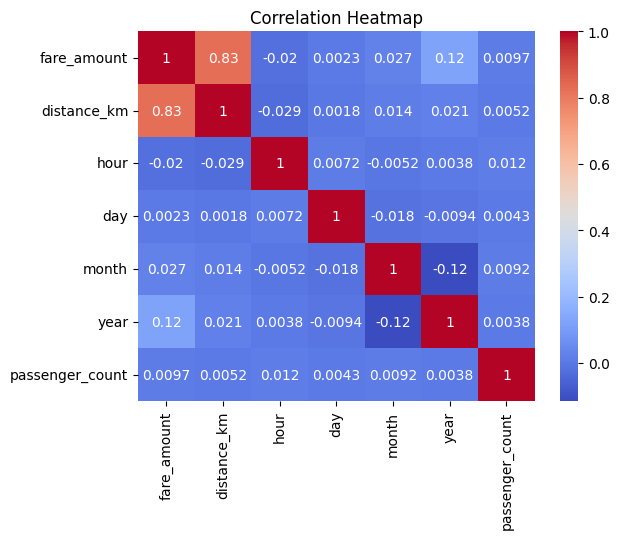

In [ ]:
# Select numerical columns
corr_df = df[['fare_amount', 'distance_km', 'hour', 'day', 'month', 'year', 'passenger_count']]
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


 4. Train Linear & Random Forest Regression Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Select features
features = ['distance_km', 'passenger_count', 'hour', 'month', 'year']
X = df[features]
y = df['fare_amount']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lr = lin_reg.predict(X_test)

# Random Forest
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)


5. Evaluate and Compare Models

In [ ]:
from sklearn.metrics import mean_absolute_error

def evaluate_model(y_true, y_pred, name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} Performance:")
    print(f"  R2 Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}\n")

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest Regression")


Linear Regression Performance:
  R2 Score: 0.6529
  RMSE: 5.4635
  MAE: 2.5260

Random Forest Regression Performance:
  R2 Score: 0.7532
  RMSE: 4.6074
  MAE: 2.3601



Feature Importance (for Random Forest)

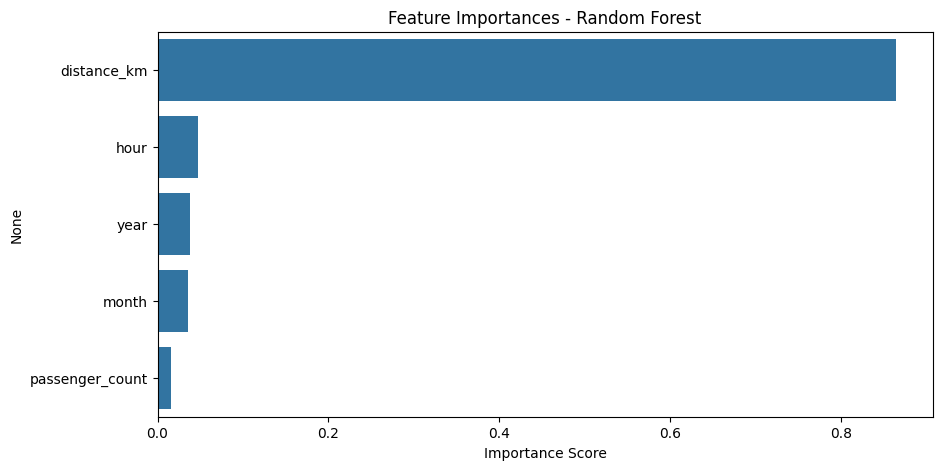

In [ ]:
importances = rf_reg.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.show()
